# TP2 : ARIMA - SARIMA

ARIMA est l’un des modèles de prévision de séries chronologiques les plus classiques. Au cours du processus de modélisation, nous voulons principalement trouver 3 paramètres. Terme d'auto-régression (AR), à savoir les décalages de la valeur précédente; Terme intégral (I) pour la différenciation non stationnaire et moyenne mobile (MA) pour le terme d'erreur.


## L'objectif pour ce tp est de :

- Comprendre ARIMA, SARIMA
- Examiner les tests nécessaires dont ARIMA a besoin pour vérifier la stationnarité
- Trouver un ensemble de paramètres à partir de tests statistiques et de visualisations

## La structure de TP :

- Introduction d'ARIMA
- Décomposer les ts
- Stationnariser les données
- Interpréter ACF et PACF
- Déterminer p, d, q
- Ajout de la saisonnalité : SARIMA



### Importation des librairies python

- seaborn (bibliothèque de visualisation de données basée sur matplotlib)


In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab style plot
import seaborn as sns # affichage
import statsmodels.api as sm # modèle stat contenant le modèle ARIMA

from scipy import stats
from scipy.stats import normaltest

color = sns.color_palette()
sns.set_style('darkgrid')


# Préparation et description des données 


- Lecture du fichier csv et conversion du champ date.

(lire le fichier avec un éditeur texte et en déduire le format

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)


In [2]:
train = pd.read_csv('/homes/x21zhang/Documents/DSTIA/donneesTP2/train.csv')
train['date'] = pd.to_datetime(train['date'])

- Décrire la structure du fichier

- Ajouter 4 colonnes, l'année, le numéro du mois, le jour dans l'année et le jour de la semaine dans les données train_df.

- Cela permettra d'analyser les données en fonction du jour dans la semaine, du mois dans l'année,...


In [3]:
train

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [4]:
# Entrainement du modèle pour store == 1 et item == 1
# Sélection des données
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]

train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.day
train_df['weekday'] = train['date'].dt.weekday

$\bullet$ **Effectuer une anayse descriptive des données**


In [5]:
train_df.describe()

,store,item,sales,year,month,day,weekday
count,1826.0,1826.0,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,1.0,1.0,19.971522,2015.000548,6.523549,15.727820,3.001643
std,0.0,0.0,6.741022,1.414407,3.449478,8.801735,1.999862
min,1.0,1.0,4.000000,2013.000000,1.000000,1.000000,0.000000
25%,1.0,1.0,15.000000,2014.000000,4.000000,8.000000,1.000000
50%,1.0,1.0,19.000000,2015.000000,7.000000,16.000000,3.000000
75%,1.0,1.0,24.000000,2016.000000,10.000000,23.000000,5.000000
max,1.0,1.0,50.000000,2017.000000,12.000000,31.000000,6.000000


Commenter vos résultats

### Affichage de la série chronologique

Pour commencer, nous voulons décomposer les données pour séparer la saisonnalité, la tendance et les résidus. 

Utilisons une fonction dans statsmodels pour nous aider à trouver la tendance.

$\bullet$ Affichage de toutes les données

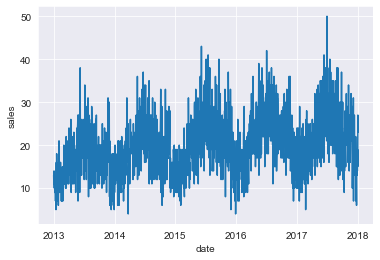

In [6]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

$\bullet$ Afficher les 28 permières valeurs

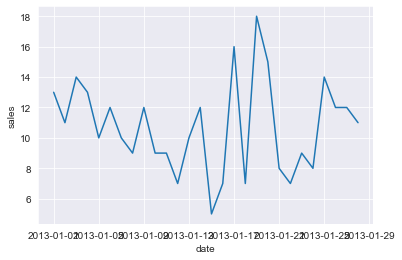

In [7]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])

$\bullet$ Afficher les boxplot sur les jours de la semaine, les mois

(fonction sns.boxplot)

$\bullet$ Commenter

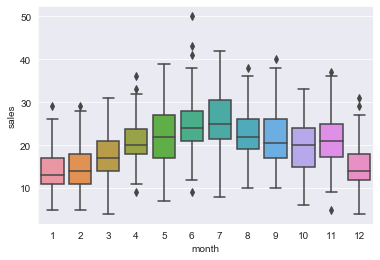

In [8]:
sns.boxplot(x="month", y="sales", data=train_df)

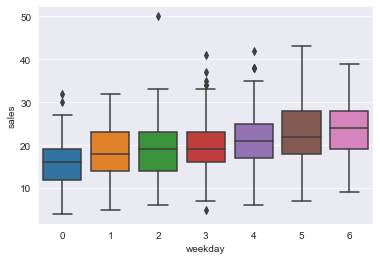

In [9]:
sns.boxplot(x="weekday", y="sales", data=train_df)

$\bullet$ Transformer 'date' en index,

$\bullet$ Transformer 'sales' en float

In [10]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


# Décomposition selon un modèle additif

Décomposition de la série (tendance, saisonnalité, erreur) en utilisant statsmodels et seasonal_decompose

(hypothèse période sur 365 jours)

<Figure size 432x288 with 0 Axes>

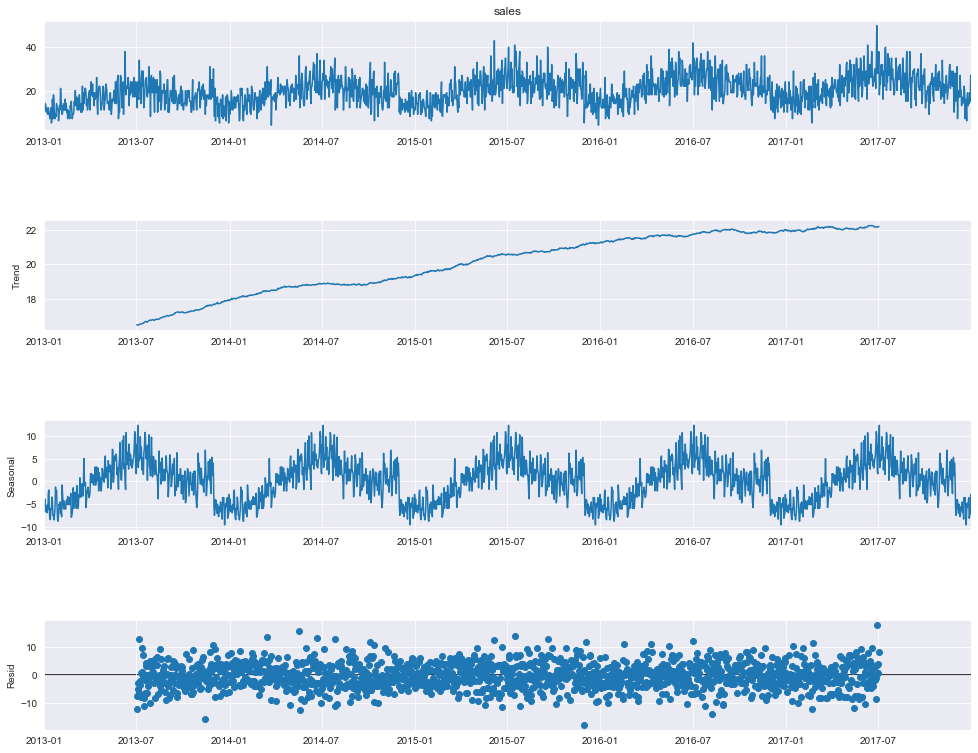

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', filt=None, period=365, two_sided=True, extrapolate_trend=0)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

- Effectuer un test de normalité sur le résidu result.resid et commenter le résultat

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

PS : attention une partie du vecteur result.resid est composé de valeurs NaN qui sont incompatible avec normaltest. IL faudra prendre la partie sans NaN de result.resid.

In [12]:
#test normalité
#from scipy.stats import normaltest
# définir et compléter le test
# afficher le résultat
#recherche de la position des NaN
import scipy
from scipy.stats import normaltest
k2, p = normaltest(result.resid[182:1644], axis=0)
print(result.resid[182:1644])
alpha = 1e-3
print("p = {}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

date
2013-07-02    -7.536917
2013-07-03   -11.920479
2013-07-04    -4.825273
2013-07-05    -2.566369
2013-07-06    -6.337602
                ...    
2017-06-28    17.908289
2017-06-29     3.653494
2017-06-30     4.176782
2017-07-01     0.811028
2017-07-02     8.391850
Name: resid, Length: 1462, dtype: float64
p = 0.19501799714043738
The null hypothesis cannot be rejected


## Stationnarisation de la série

Pourquoi est-ce important ? Lors de l'exécution d'une régression linéaire, l'hypothèse est que toutes les observations sont indépendantes les unes des autres. 
Dans une série chronologique, cependant, nous savons que les observations dépendent du temps. Il s'avère que beaucoup de bons résultats valent pour les variables aléatoires indépendantes (loi des grands nombres et théorème limite central), pour les variables aléatoires stationnaires. Donc, en rendant les données stationnaires, nous pouvons réellement appliquer des techniques de régression à cette variable dépendante du temps.

Vous pouvez vérifier la stationnarité d'une série chronologique de deux manières. Le premier est en regardant les données. En visualisant les données, il devrait être facile d'identifier un changement de moyenne ou de variation des données. 

Visuellement, la série ne semble pas stationnaire.

En utilisant le test de Dickey-Fuller, il est possible de dire si la série est stationnaire ou non. Si la «statistique de test» est supérieure à la «valeur critique», la série temporelle est stationnaire. 

Nous utiliserons la librairie python statsmodels.

https://www.statsmodels.org/stable/index.html


La fonction suivante permet d'afficher une moyenne mobile, une variance (mobile), les données et le résutat d'un test de stationnarité (Dicker-Fuller)

- Préciser le test permettant de dire stationnaire or not stationnaire

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    #rolmean = timeseries.rolling(window).mean()
    #rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    #fig = plt.figure(figsize=(12, 8))
    #orig = plt.plot(timeseries, color='blue',label='Original')
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    #plt.legend(loc='best')
    #plt.title('Rolling Mean & Standard Deviation')
    #plt.show()
    
    #Perform Dickey-Fuller test:
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    print('Resultats du Test de Dickey-Fuller :')
    dftest = adfuller(timeseries, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistique','p-value','#Lags utilisés','Nombre d observations utilisées'])
    for key,value in dftest[4].items():
        dfoutput['Valeur critique (%s)'%key] = value
    pvalue = dftest[1]
    if (pvalue<cutoff):
        print('p-value = %.4f. La série est vraisemblablement stationnaire.' % pvalue)
    else:
        print('p-value = %.4f. La série est vraisemblablement non stationnaire.' % pvalue)
    
    print(dfoutput)

$\bullet$  Tester la stationnarité et commenter (influence du choix de la valeur critique)

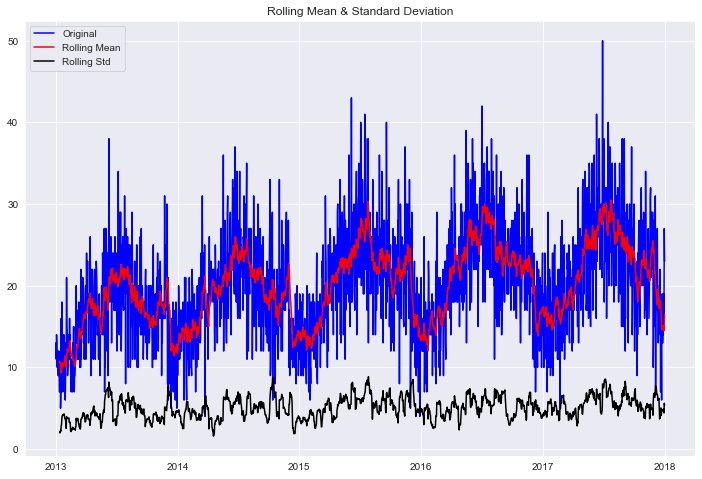

Resultats du Test de Dickey-Fuller :
p-value = 0.0226. La série est vraisemblablement non stationnaire.
Test Statistique                     -3.157671
p-value                               0.022569
#Lags utilisés                       23.000000
Nombre d observations utilisées    1802.000000
Valeur critique (1%)                 -3.433984
Valeur critique (5%)                 -2.863145
Valeur critique (10%)                -2.567625
dtype: float64


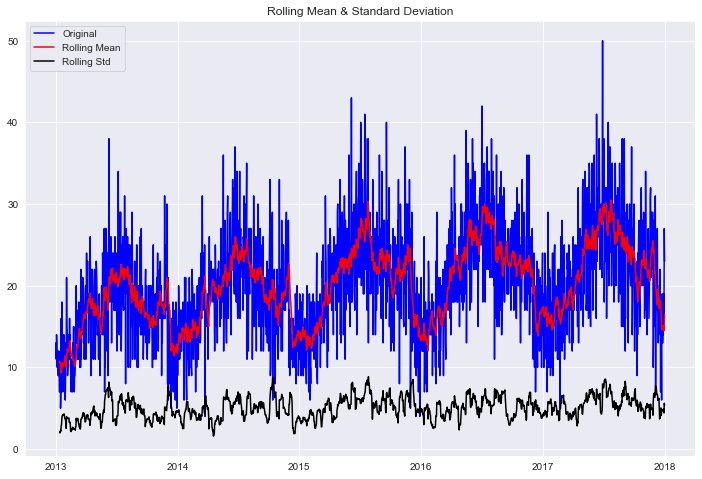

Resultats du Test de Dickey-Fuller :
p-value = 0.0226. La série est vraisemblablement stationnaire.
Test Statistique                     -3.157671
p-value                               0.022569
#Lags utilisés                       23.000000
Nombre d observations utilisées    1802.000000
Valeur critique (1%)                 -3.433984
Valeur critique (5%)                 -2.863145
Valeur critique (10%)                -2.567625
dtype: float64


In [14]:
# valeur critique choisi : 0.01
test_stationarity(train_df['sales'],cutoff = 0.01)

# valeur critique choisi : 0.05
test_stationarity(train_df['sales'],cutoff = 0.05)

Commenter

Pour le même ensemble de données, l'hypothèse de test est réalisée et le résultat du test est lié à la valeur de cutoff que nous définissons : plus la valeur de cutoff que nous choisissons est petite, moins nous avons de tolérance pour la possibilité d'erreur de prediction. Ici p-value = 0.022569, valeur critique (1%) < p-value < valeur critique (5%)

$\bullet$ Appliquer ce même test sur la série des différence d'ordre 1

$\bullet$ Commenter (comparer avec le résultat précédent)

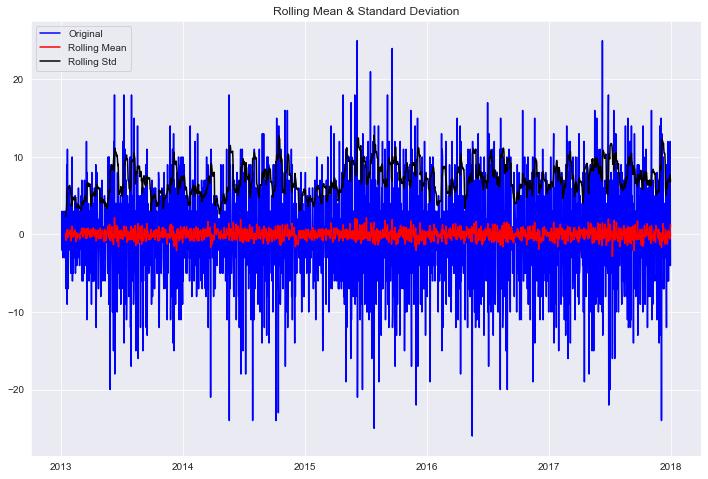

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -1.267679e+01
p-value                            1.210928e-23
#Lags utilisés                     2.200000e+01
Nombre d observations utilisées    1.802000e+03
Valeur critique (1%)              -3.433984e+00
Valeur critique (5%)              -2.863145e+00
Valeur critique (10%)             -2.567625e+00
dtype: float64


In [23]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, cutoff = 0.05)

Commenter



## ACF et PACF

L'autocorrélation partielle au décalage $k$ est la corrélation obtenue après suppression de l'effet des éventuelles corrélations dues aux termes ayant des retards plus courts.



À partir du graphique d'autocorrélation, nous pouvons dire si nous devons ou non ajouter des termes MA. Nous savons, à partir du graphique d'autocorrélation partielle, que nous devons ajouter des termes AR.



Références:

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

$\bullet$ Afficher et commenter l'ACF et le PACF sur la série temporel train_df.sales

plot_acf et plot_pacf a pour première entrée les valeurs de la série

https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

In [16]:
train_df.sales

date
2013-01-01    13.0
2013-01-02    11.0
2013-01-03    14.0
2013-01-04    13.0
2013-01-05    10.0
              ... 
2017-12-27    14.0
2017-12-28    19.0
2017-12-29    15.0
2017-12-30    27.0
2017-12-31    23.0
Name: sales, Length: 1826, dtype: float64

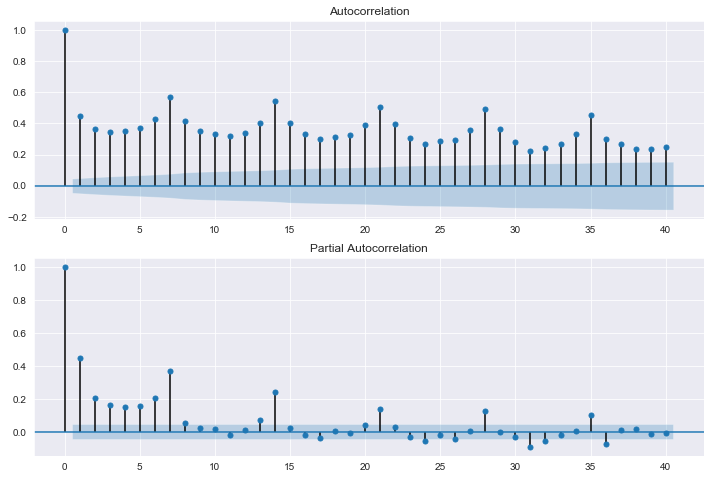

In [17]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1) 
#fig = sm.graphics.tsa.plot_acf(#to fill, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(# to fill, lags=40, ax=ax2)# 
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)

$\bullet$ Recommencer le même exercice sur la série des différences d'ordre 1

$\bullet$ Commenter

$\bullet$ Choisir les ordres p,q,d du modèle

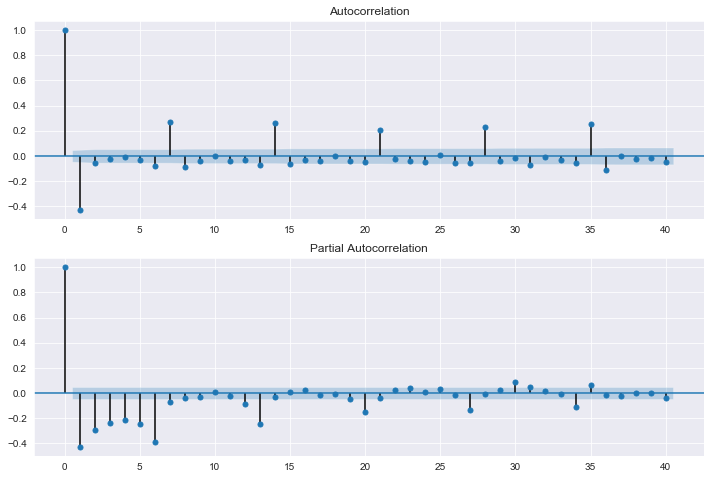

In [18]:
diff = train_df.diff()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff.sales[1:], lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff.sales[1:], lags=40, ax=ax2)

Cet ensemble de fonctions n'est pas stationnaire, mais après la dérivation, nous obtenons les données stationnaires. Parce que c'est une dérivée de premier ordre, d=1 ; l'autocorrélation converge vers 0 après t>1 : q=0 ; l'autocorrélation partielle converge vers 0 après t>6 : p=6

Construire le modèle - Déterminer p, d, q



Référence:

https://www.researchgate.net/post/How_does_one_determine_the_values_for_ARp_and_MAq
https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms/281726#281726
https://stats.stackexchange.com/questions/134487/analyse-acf-and-pacf-plots?rq=1

$\bullet$ Choisir des valeurs de p, d et q.

In [19]:
# Mettre à jour les valeurs en fonction de vos choix
p = 6
d = 1
q = 1
arima_mod6 = sm.tsa.ARIMA(train_df.sales, (p,d,q)).fit(disp=False)
print(arima_mod6.summary())

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5592.108
Method:                       css-mle   S.D. of innovations              5.179
Date:                Mon, 14 Mar 2022   AIC                          11202.216
Time:                        08:22:21   BIC                          11251.800
Sample:                    01-02-2013   HQIC                         11220.507
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0038      0.023      0.166      0.868      -0.041       0.049
ar.L1.D.sales    -0.6344      0.059    -10.801      0.000      -0.750      -0.519
ar.L2.D.sales    -0.6173      0.047    -

- Analyser le résultat

- etude du résidus
    - affiche de celui-ci
    - affichage de l'histogramme (et d'un modèle de loi normale)
    - test sur la stationnarité
    - affichage du pacf et de l'acf

- Commenter et analyser

NormaltestResult(statistic=14.314849811147944, pvalue=0.0007790581206467951)


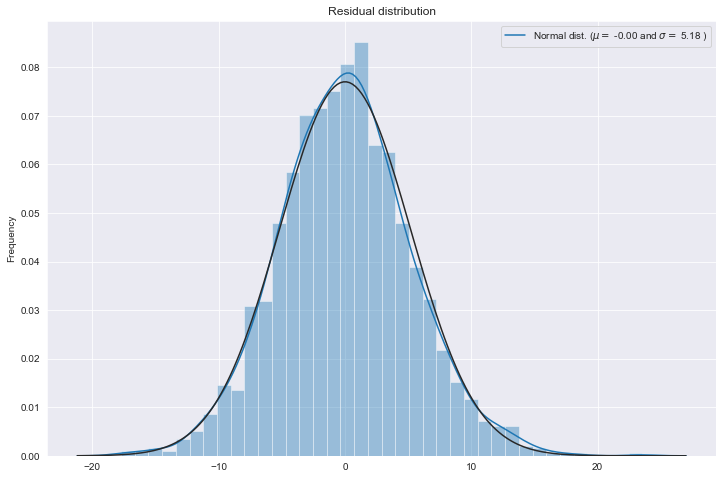

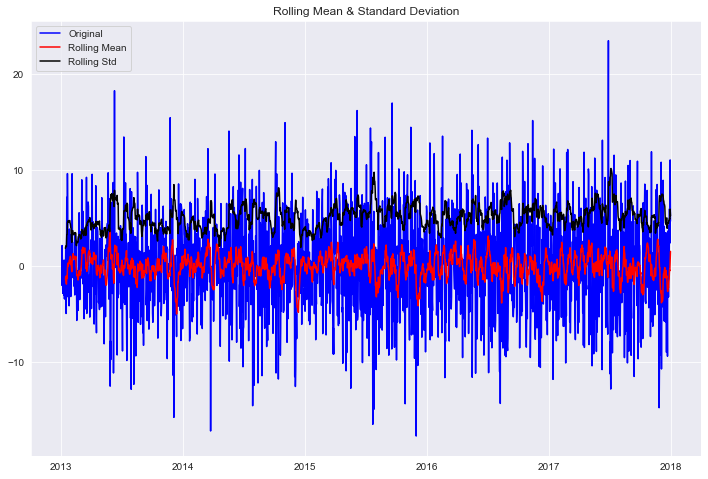

Resultats du Test de Dickey-Fuller :
p-value = 0.0000. La série est vraisemblablement stationnaire.
Test Statistique                  -1.031798e+01
p-value                            3.061452e-18
#Lags utilisés                     2.300000e+01
Nombre d observations utilisées    1.801000e+03
Valeur critique (1%)              -3.433986e+00
Valeur critique (5%)              -2.863146e+00
Valeur critique (10%)             -2.567625e+00
dtype: float64


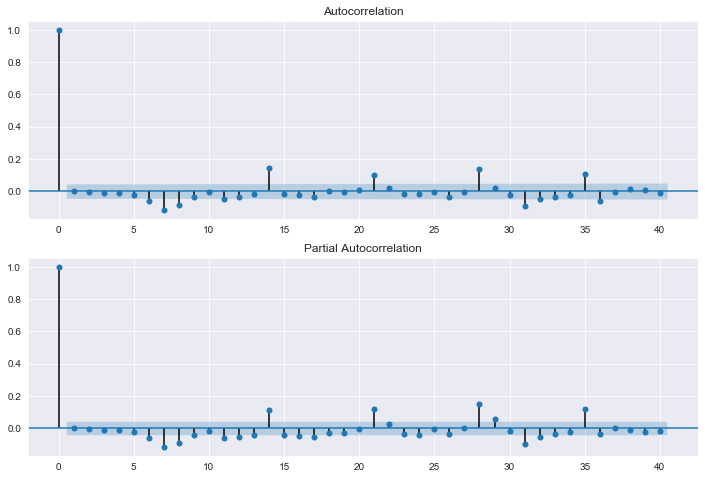

In [21]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

test_stationarity(resid)


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)




 Résidu est stationnaire. Le distribution du résidu ressemble au distribution gaussien, mais le p value du normaltest < 0.05, l'hypothèse nul doit être rejetée, on ne peux pas dire que c'est gaussien .  La distribution de l'autocorrélation et de l'autocorrélation partielle des résidus est très similaire, et bien que leurs valeurs soient faibles, nous pouvons trouver une autocorrélation et une autocorrélation partielle relativement importantes aux jours 7, 14 et 21. Ce résidu est donc stable, mais pas un bruit blanc gaissien . 

### Méthode brute

une autre façon de choisir le bon triplet est d'en tester un certain nombre et de choisir celui qui minimise un certain critère (AIC, BIC, MAE,...)


In [49]:
# Création des triplets

import warnings
import itertools

# construction des différents triplets (p, d, q) qui seront testés
# Define the p, d and q parameters to take any value between 0 and 2
p = range(5, 8)
d = range(0, 2)
q = range(0, 6)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [39]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

# remplacer ??? par le critère choisi
AIC_min = 1000000.

for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_df.sales,
                                            order=param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
        
            if results.aic < AIC_min:
                print('val min ARIMA{} - AIC:{}'.format(param, results.aic))
                AIC_min = results.aic
            
        except:
            continue

ARIMA(5, 0, 0) - AIC:11591.433501461517
val min ARIMA(5, 0, 0) - AIC:11591.433501461517
ARIMA(5, 0, 1) - AIC:11281.899424183823
val min ARIMA(5, 0, 1) - AIC:11281.899424183823
ARIMA(5, 0, 2) - AIC:11285.139386466695
ARIMA(5, 0, 3) - AIC:11274.972410362228
val min ARIMA(5, 0, 3) - AIC:11274.972410362228
ARIMA(5, 0, 4) - AIC:11283.344828955473
ARIMA(5, 0, 5) - AIC:11091.401188981532
val min ARIMA(5, 0, 5) - AIC:11091.401188981532
ARIMA(5, 1, 0) - AIC:11479.175288922455
ARIMA(5, 1, 1) - AIC:11244.120729265695
ARIMA(5, 1, 2) - AIC:11271.050850099411
ARIMA(5, 1, 3) - AIC:11081.677443129403
val min ARIMA(5, 1, 3) - AIC:11081.677443129403
ARIMA(5, 1, 4) - AIC:11043.976882216131
val min ARIMA(5, 1, 4) - AIC:11043.976882216131
ARIMA(5, 1, 5) - AIC:11032.451241943363
val min ARIMA(5, 1, 5) - AIC:11032.451241943363
ARIMA(6, 0, 0) - AIC:11478.58384347715
ARIMA(6, 0, 1) - AIC:11245.934544992579
ARIMA(6, 0, 2) - AIC:11257.902096785067
ARIMA(6, 0, 3) - AIC:11260.94927227068
ARIMA(6, 0, 4) - AIC:11101

Avez-vous trouver un résultat similaire ?

Si non quel modèle choissiez-vous ?

# Affichage d'une prédiction

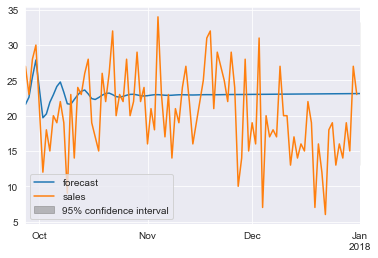

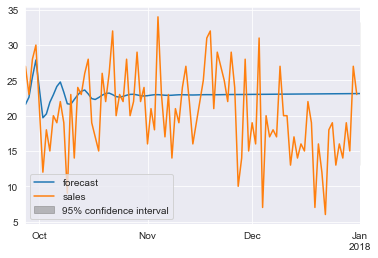

In [40]:
start_index = 1730
end_index = 1826
arima_mod6.plot_predict(start = start_index, end= end_index, dynamic= True)  



## Modèle SARIMA

Bien que le graphique ressemble beaucoup à une distribution normale. Mais cela a échoué au test. Nous constatons également une corrélation récurrente dans ACF et PACF. Nous devons donc faire face à la saisonnalité.

Considérez la saisonnalité affectée par SARIMA

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
https://barnesanalytics.com/sarima-models-using-statsmodels-in-python

- Choississer une saisonnalité en fonction de vos observations de l'auto-corrélation et de l'auto-corrélation partielle.
- Afficher le modèle obtenu

In [43]:
# remplace ?? par l'ordre de la saison que vous avez choisi


sarima_mod6 = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,0,1), seasonal_order=(2,1,2,7)).fit()


- Etudier la normalité, l'acf et le pacf du résidu

NormaltestResult(statistic=23.897367600438372, pvalue=6.467740095305545e-06)


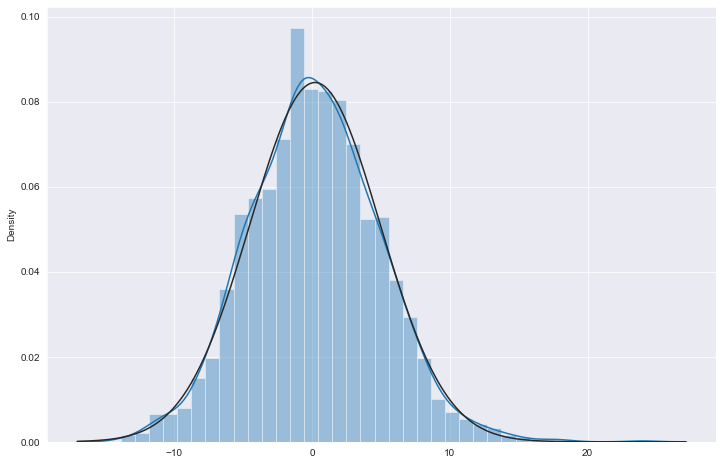

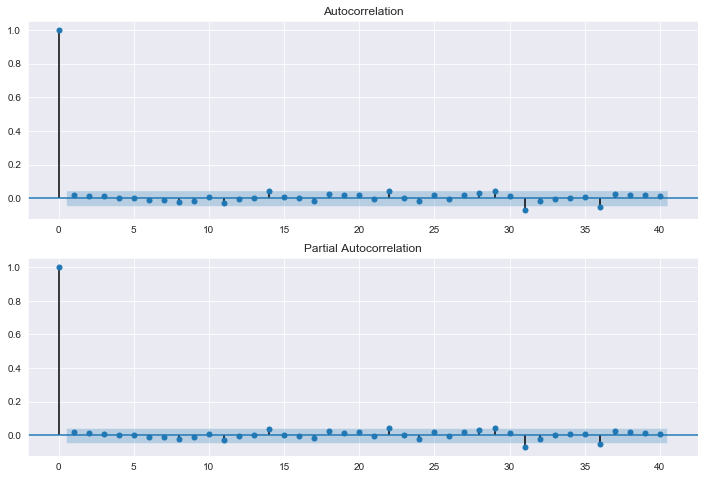

In [45]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)
fig = sns.distplot(resid ,fit = stats.norm, ax = ax0)

# à compléter
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

- Comparaison du modèle ARIMA et SARIMA

  - analyse des résultats du test de normalité
  - analyse des formes de l'histogramme du résidu

## Etude de l'impact sur la prédiction

Pour le modèle SARIMA, nous pouvons voir plus clairement sur l'histogramme de la distribution résiduelle qu'il ne s'agit pas d'une distribution gaussienne et la valeur p du test normal est beaucoup plus petite. L'autocorrélation et l'autocorrélation partielle des résidus convergent toutes deux vers zéro.

Faire des prévisions et des évaluations

Prendre les 30 derniers jours d’entraînement définis comme données de validation

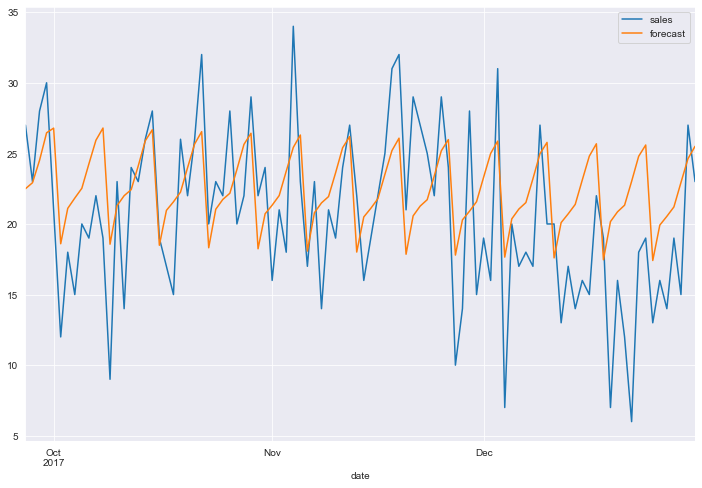

In [46]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [47]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [48]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 29.34 % 
SMAPE: 23.08 %


- Comparer le résultat obtenu avec celui du modèle ARMA (commenter)